# KCMC Problem

We have a set of points of interest (POIs) that are static locations in space that continuously produce information. To gather that information, the POIs must be monitored by SENSORS.

Sensors have a limited "sensing range", so often a sensor cannot monitor a POI because it is too far away, "out of range". When a POI is monitored by a sensor, it must be within the sensing range of the sensor, and we say that the POI is "covered" by the sensor. A single sensor can monitor all the POIs that are within its sensing range.

We have several static, immovable locations in space in which sensors can be installed. Those locations are often called "installation spots". A single sensor may be installed in each spot.

Often a single sensor cannot monitor a POI to satisfaction (a condition called "insufficient quality of service"), so each POI must be covered by at least $\dot{K}$ sensors. The number of sensors that cover a POI is called its "coverage".

Sensors are not designed to store or process the data collected. Instead, each sensor must transmit the data it has collected to other sensors. Those other sensors may re-transmit the data to other sensors, until it reaches a special sensor called SINK. A sink is a sensor capable of storing or processing data. We often cannot choose where the sinks are installed.

Sensors are prone to failure, so we ensure that the data from every POI is continually transmitted to the sink by guaranteeing that we have at least $\dot{M}$ different sets of sensors capable of transmitting the data from each POI to a sink. Those sets must be disjunct - no sensor may belong to more than one set. Disjunct sets guarantee that even if failures in a set render it unable to get data from a POI to any sink, the sensors in other sets can deliver it. The number of disjunct sets of sensors that connect a POI to a sink is called its "connectivity".

Sensors have a cost, so we want to install as few as possible while still guaranteeing that each POI is covered with at least $\dot{K}$ different sensors and the data form each POI have at least $\dot{M}$ different paths to a sink. This is the $\dot{K}$-Coverage $\dot{M}$-Connectivity problem.

We represent a instance of the KCMC problem as a [graphs](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)). In discrete mathematics, a graph is an structure formed by "nodes" or "vertices" (usually represented as circles or dots) distributead in any way in the space, since the exact position of each vertice is not relevant to the graph. Instead, the connections between nodes (the edges) is the information we are concerned with.

In our graph representation, each node in the graph may be:
- installation spot for a sensor
- a POI
- a sink

If a node represents a POI, it is connected to all installation spots where a sensors would be able to cover the POI.
If the node represents a sink, it is connected to all instalation spots where sensors would be capable of transmitting data to the sink.
If the node represent an installation spot for a sensor, it is connected to the POIs an installed sensor would able to cover, and all the sinks and other sensor installation spots that a sensor placed at the current spot would be able to communicate with.

Our strategy to solve the KCMC problem is to find $\dot{M}$ sets of sensor installation spots that form [Steiner trees](https://en.wikipedia.org/wiki/Steiner_tree_problem). Steiner trees are sub-graphs that connect a subset of nodes (the POIs and sinks) using as few as possible nodes that are not in the subset.
The resulting $\dot{M}$ minimal disjunct Steiner Trees contain all the sensor instalation spots we require to guarantee that each POI in the KCMC instance has at least $\dot{M}$ connectivity.
Then we simply add as few as possible sensor installation spots so that each POI has at least $\dot{K}$ coverage.

A more interesting way to describe our strategy is using an integer-linear programming [(ILP) formulation](https://en.wikipedia.org/wiki/Integer_programming), in which we use discrete linear algebra equations and inequations to describe the elements and constraints of the KCMC problem.
ILP formulations are an standardized way of describing problems, and have many useful mathematical properties.

In this notebook, we explore our ILP formulation for the KCMC problem and implement it to obtain solutions. 

## Imports & Data gathering

The code below imports the [GUROBI](https://en.wikipedia.org/wiki/Gurobi) Optimizer, a proprietary [Solver](https://en.wikipedia.org/wiki/Solver) software capable of quickly finding the best possible solution to any problem expressed as a valid ILP formulation, given small enough instances.

The KCMC object imported is a custom python facility that reads a given KCMC instance (file) and exposes its attributes.

In [1]:
import gurobipy as gp
from gurobipy import GRB

from instance_parser import KCMC

The code below imports an instance of the KCMC problem and exposes its attributes as several variables relevant to the KCMC problem:

- edges_E: the set $E$ of pairs of elements (tuples). Each element in each tuple is a component of the KCMC problem, represented by a string with a prefix for each kind of component, and a suffix with the identification number of the element;
    - a POI (prefix "p")
    - a SENSOR (prefix "v")
    - a SINK (prefix "s")
- pois_P: the set $P$ of POIs in the KCMC instance, represented as described above;
- terminals_T: an alias to the variable pois_P (set $T$);
- sensors_V: the set $V$ of SENSORS in the KCMC instance, represented as described above;
- sinks_S: the set $S$ of SINKS in the KCMC instance, represented as described above;
- nodes_N: the union of sets pois_P, sensors_V and sinks_S - all the elements in the KCMC instance (set $N$);
- trees_M: all the integers in the interval $\big[0..\dot{M}\big[$ - set $M$.

It is important to remark that variable edges_E lists not only each edge from node A to B, but also its reverse edge (B to A). We have another variable, unidirected_edges_EU, that contains onthe the edges in one direction.

In [2]:
kcmc = KCMC('example_instance.txt')

edges_E = kcmc.edges(poi_prefix='p',
                     sensor_prefix='v',
                     sink_prefix='s',
                     add_reverse=True,
                     avoid_poi_starter_edges=True)

unidirected_edges_EU = set()
for edge in edges_E:
    if edge not in unidirected_edges_EU:
        if (edge[1], edge[0]) not in unidirected_edges_EU:
            unidirected_edges_EU.add(edge)

pois_P = sorted(set([i[1] for i in edges_E if i[1].startswith('p')]))
terminals_T = pois_P
sensors_V = sorted(set([i[0] for i in edges_E if i[0].startswith('v')]))
sink_S = sorted(set([i[0] for i in edges_E if i[0].startswith('s')]))
nodes_N = pois_P + sensors_V + sink_S
trees_M = list(range(kcmc.m))

len(trees_M), len(pois_P), len(sensors_V), len(sink_S), len(nodes_N), len(edges_E), len(unidirected_edges_EU)

PARSED RAW KCMC INSTANCE (2 2) { 25 100 3 }
TRANSFORMED KCMC INSTANCE TO SINGLE-SINK (ANY SINK) (2 2) { 25 100 1 }


(2, 25, 100, 1, 126, 1701, 952)

The instance of the KCMC problem provided might have more than one sink. In this case, the KCMC object automatically converts it to a _single-sink equivalent_ instance using the following algorithm:

- Create a new "sinthetic sink", not connected to anything 
- For each sink:
    - For each sensor connected to the sink:
        - Create a new "sinthetic sensor"
        - Connect the sinthetic sensor to all sensors that the current sink is connected to
        - Add the synthetic sensor to the set of sensors
        - Connect the synthetic sensor to the synthetic sink
    - Remove the sink from the set of sinks

The resulting KCMC instance has a single sink and several "synthetic sensors" that must not be counted in the totall tally of sensors used in the solution of the KCMC problem. 

## Variables

Variables are structures that store information about the KCMC problem.
A variable can be seen as an array of dimensions relative to the elements of the problem.

In this section, we describe and implement the two variables used in our ILP formulation.
But first, we create a new GUROBI model object. It will print information about this copy of the GUROBI software.

Then, we add variable $x_j^m$ to the model.

### $x_j^m$
This binary variable marks the usage of sensor $j \in V$ at the $m$-th Steiner tree ($m \in M$).

It can be seen as a 2-D array, the first dimension representing sensor placement spots and the second the $M$ Steiner trees. Thus, we have $|M| * |V|$ possible values for this variable.

In [3]:
model = gp.Model('KCMC')

Academic license - for non-commercial use only - registered to josefrf@ufmg.br
Using license file /opt/gurobi/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID


In [4]:
x_var = model.addVars([(j, m)
                       for j in sensors_V
                       for m in trees_M],
                      vtype=GRB.BINARY, name="x")

In [5]:
len(x_var)

200

- Then, we add variable $y_{ji}^{km}$ to the model.

### $y_{ji}^{km}$
This binary variable marks the usage of edge $(j,i) \in E$ at the $m$-th Steiner tree ($m \in M$) that connects POI $k \in P$ to the sink.

It can be seen as a 4-D array, the first two dimensions representing the elements in the edges of the graph, the third being a POI, and the the forth being the $M$ Steiner trees.
Thus, we have $|E| * |P| * |M|$ possible values for this variable.

It is important to remark that set $E$ contains each edge (A,B) and its mirror edge (B,A).

In [6]:
y_var = model.addVars([(e[0], e[1], k, m)
                       for e in edges_E
                       for k in terminals_T
                       for m in trees_M],
                      vtype=GRB.BINARY, name='y')

In [7]:
len(y_var)

85050

## Objective Function

The objective function in an ILP formulation describes how the result of each intermediate solution will be evaluated. The objective of our optimization is to MINIMIZE the result of the objective function.


### OBJECTIVE: MINIMIZE $\sum_{j \in V}\sum_{m \in M} x_{j}^{m} $

In [8]:
model.setObjective(x_var.sum('*', '*'), GRB.MINIMIZE)

## Constraints

Constraints are rules limiting to the values that the variables described above may assume.
In this section we describe and implement the constraints.

### $\sum_{m \in M} x_j^m <= 1 \;\;\;\;\;\;\;\; \forall j \in V$

The first constraint is simple - each sensor installation spot can be used only once, regardless of which of the M Steiner trees it is a part of.

In [9]:
single_use_sensor = model.addConstrs(
    x_var.sum(j, '*') <= 1
    for j in sensors_V
)

### $\sum_{(i,j) \in E} y_{ij}^{km} \leq x_j^m, \quad \forall\, j \in V, k \in T, m \in M$
The second constraint requires that, for an edge to be a part of an steiner tree, the sensor at its ending must be installed


In [10]:
edge_only_if_sensor_installed = model.addConstrs(
    y_var.sum('*', j, k, m)
 <= x_var[j, m]
    for j in sensors_V
    for k in terminals_T
    for m in trees_M
)

### Third constraint - three parts

The third constraint has three parts

#### $\sum_{(s,i) \in E} y_{si}^{km} - \sum_{(i,s) \in E} y_{is}^{km} = 1$

In [11]:
end_in_sink = model.addConstrs(
    y_var.sum(s, '*', k, m)
  - y_var.sum('*', s, k, m)
 == 1
    for s in sink_S
    for k in terminals_T
    for m in trees_M
)

#### $\sum_{(k,i) \in E} y_{ki}^{km} - \sum_{(i,k) \in E} y_{ik}^{km} = -1$

In [12]:
end_in_poi = model.addConstrs(
    y_var.sum(k, '*', k, m)
  - y_var.sum('*', k, k, m)
 == -1
    for k in terminals_T
    for m in trees_M
)

#### $\sum_{(j,i) \in E} y_{ji}^{km} - \sum_{(i,j) \in E} y_{ij}^{km} = 0$

In [13]:
end_in_sensor = model.addConstrs(
    y_var.sum(v, '*', k, m)
  - y_var.sum('*', v, k, m)
 == 0
    for v in sensors_V
    for k in terminals_T
    for m in trees_M
)

### $\sum y_{ij}^{km} + \sum y_{ji}^{km} \le 1$

The last constraint means that for a given steiner tree, only an edge or its inverse can be a part of the tree

In [14]:
one_way_edge = model.addConstrs(
    y_var.sum(i, j, k, m)
  + y_var.sum(j, i, k, m)
 <= 1
    for i, j in unidirected_edges_EU
    for k in terminals_T
    for m in trees_M
)

## Runtime

In [15]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Academic license - for non-commercial use only - registered to josefrf@ufmg.br
Optimize a model with 57800 rows, 85250 columns and 323356 nonzeros
Model fingerprint: 0xed9b2948
Variable types: 0 continuous, 85250 integer (85250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 10150 rows and 5510 columns
Presolve time: 0.66s
Presolved: 47650 rows, 79740 columns, 307696 nonzeros
Variable types: 0 continuous, 79740 integer (79740 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   22631    2.0647450e+01   0.000000e+00   2.528617e+04      5s
Concurrent spin time: 0.00s

Solved with dual simpl

In [16]:
sensors_used = {}
inverse_sensors_used = {}

for key, value in sorted(x_var.items(),
                         key=lambda pair: (int(pair[0][0][1:]), pair[0][1])):
    sensor, tree = key
    if not hasattr(value, 'x'):
        print('Condição desconhecida!')
        break
    elif value.x == 0.0:
        # print(f'Sensor {sensor} not used in Steiner tree {tree}')
        pass
    elif value.x == 1.0:
        print(f'Sensor {sensor} USED in Steiner tree {tree}')
        if tree not in sensors_used:
            sensors_used[tree] = []
        sensors_used[tree].append(sensor)
        inverse_sensors_used[sensor] = tree
    else:
        print('Condição desconhecida!')
        break

Sensor v0 USED in Steiner tree 0
Sensor v8 USED in Steiner tree 1
Sensor v10 USED in Steiner tree 1
Sensor v14 USED in Steiner tree 0
Sensor v15 USED in Steiner tree 1
Sensor v16 USED in Steiner tree 0
Sensor v21 USED in Steiner tree 0
Sensor v25 USED in Steiner tree 0
Sensor v47 USED in Steiner tree 1
Sensor v52 USED in Steiner tree 1
Sensor v53 USED in Steiner tree 0
Sensor v54 USED in Steiner tree 1
Sensor v59 USED in Steiner tree 0
Sensor v64 USED in Steiner tree 0
Sensor v75 USED in Steiner tree 0
Sensor v76 USED in Steiner tree 0
Sensor v80 USED in Steiner tree 1
Sensor v88 USED in Steiner tree 1
Sensor v90 USED in Steiner tree 1
Sensor v97 USED in Steiner tree 1
Sensor v99 USED in Steiner tree 1


## PLOT

### Max-Graph

## Visualização completa

No grafo abaixo, em vermelho estão SENSORES NÃO UTILIZADOS. Em azul e roxo estão os sensores utilizados em cada uma das duas steiner trees, e em verde estão os POIs. A única sink está em preto.

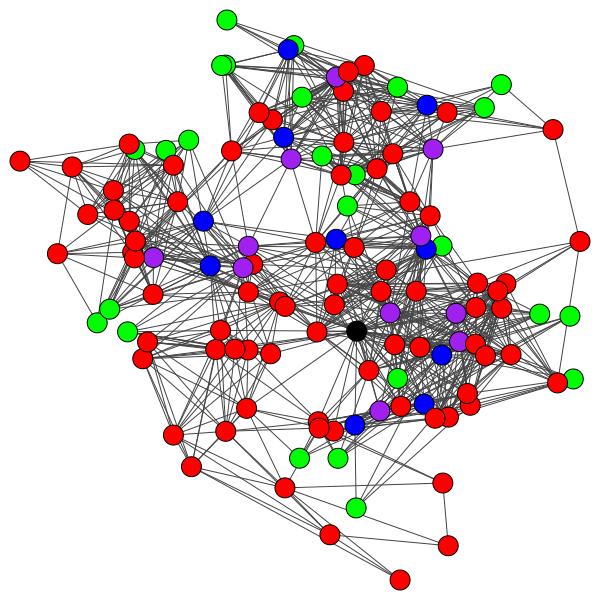

In [17]:
from igraph import Graph, plot

splits = set([f'v{v}' for v in kcmc.splitted_sinks.keys()])

g = Graph()
g.add_vertices(pois_P)
g.add_vertices(sensors_V)
g.add_vertices(sink_S)
g.add_edges(sorted([e for e in unidirected_edges_EU
                    if (e[0] in g.vs["name"]) and (e[1] in g.vs["name"])]))

layout = g.layout("kk")  # Kamada-Kawai Force-Directed algorithm

# g.vs["label"] = g.vs["name"]  # Set the NAME of the node as its label


color_dict = {"p": "green", "v": "red", "s": "black", 'split_sink': 'grey',
              "tree_0": "blue", "tree_1": "purple"}

def get_color(node):
    if node in splits:
        return color_dict['split_sink']
    if node in inverse_sensors_used:
        return color_dict["tree_"+str(inverse_sensors_used[node])]
    return color_dict[node[0]]


g.vs["color"] = [get_color(node) for node in g.vs["name"]]

plot(g, layout=layout)

### Min-Graph

Visualização do grafo anterior, após remover os sensores não-utilizados

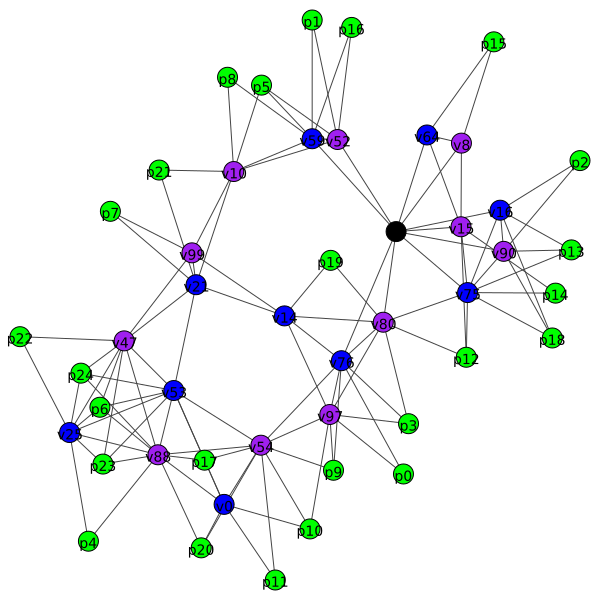

In [18]:
g = Graph()

minimal_nodes = (
    pois_P + sink_S
  + list(inverse_sensors_used.keys())
)

g.add_vertices(minimal_nodes)
g.add_edges(sorted([e for e in unidirected_edges_EU
                    if (e[0] in g.vs["name"]) and (e[1] in g.vs["name"])]))

layout = g.layout("kk")  # Kamada-Kawai Force-Directed algorithm

g.vs["label"] = g.vs["name"]  # Set the NAME of the node as its label


g.vs["color"] = [get_color(node) for node in g.vs["name"]]

plot(g, layout=layout)